In [1]:
%load_ext autoreload
%autoreload 2
import warnings
import numpy as np
import time
import os
from dotenv import load_dotenv
os.environ["USE_PYGEOS"] = "0"
import napari_sparrow as nas
from spatialdata import read_zarr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import sample 
import scanpy as sc
import seaborn as sns
import anndata as ad
%run own_and_modified_functions.ipynb
warnings.simplefilter(action='ignore')

the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","SCIPY"]


In [2]:
OUTPUT_DIR = '/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data'

In [3]:
anndataA11_all = sc.read(OUTPUT_DIR + '/' + 'A1-1/anndataNucA11_all.h5ad')
anndataA12_all = sc.read(OUTPUT_DIR + '/' + 'A1-2/anndataNucA12_all.h5ad')
anndataC2_all = sc.read(OUTPUT_DIR + '/' + 'C2/anndataNucC2_all.h5ad') 
anndataD21_all = sc.read(OUTPUT_DIR + '/' + 'D2-1/anndataNucD21_all.h5ad')

In [4]:
# Give Leiden clusters unique numbers over all samples
n_leiden_A11 = len(np.unique(anndataA11_all.obs['leiden']))
n_leiden_A12 = len(np.unique(anndataA12_all.obs['leiden']))
n_leiden_C2 = len(np.unique(anndataC2_all.obs['leiden']))
n_leiden_D21 = len(np.unique(anndataD21_all.obs['leiden']))
anndataA11_all.obs['leiden'] = anndataA11_all.obs['leiden'].astype(int)
anndataA12_all.obs['leiden'] = anndataA12_all.obs['leiden'].astype(int) + n_leiden_A11
anndataC2_all.obs['leiden'] = anndataC2_all.obs['leiden'].astype(int) + n_leiden_A11 + n_leiden_A12
anndataD21_all.obs['leiden'] = anndataD21_all.obs['leiden'].astype(int) + n_leiden_A11 + n_leiden_A12 + n_leiden_C2
# reset to string
anndataA11_all.obs['leiden'] = anndataA11_all.obs['leiden'].astype(str)
anndataA12_all.obs['leiden'] = anndataA12_all.obs['leiden'].astype(str)
anndataC2_all.obs['leiden'] = anndataC2_all.obs['leiden'].astype(str)
anndataD21_all.obs['leiden'] = anndataD21_all.obs['leiden'].astype(str)
# make categorical
anndataA11_all.obs['leiden'] = anndataA11_all.obs['leiden'].astype('category')
anndataA12_all.obs['leiden'] = anndataA12_all.obs['leiden'].astype('category')
anndataC2_all.obs['leiden'] = anndataC2_all.obs['leiden'].astype('category')
anndataD21_all.obs['leiden'] = anndataD21_all.obs['leiden'].astype('category')

In [5]:
# concatenate all anndata objects
anndata_samples_together = anndataA11_all.concatenate(anndataA12_all, anndataC2_all, anndataD21_all)

In [6]:
print(anndataA11_all.obs.shape)
print(anndataA12_all.obs.shape)
print(anndataC2_all.obs.shape)
print(anndataD21_all.obs.shape)
print(anndata_samples_together.obs.shape) # batch 0 = A1-1, batch 1 = A1-2, batch 2 = C2, batch 3 = D2-1

(11283, 96)
(8695, 96)
(27133, 96)
(12519, 96)
(59630, 97)


In [7]:
anndata_samples_together.obs.columns

Index(['region', 'instance', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes',
       'pct_counts_in_top_5_genes', 'n_counts', 'shapeSize', 'leiden',
       'portal_vein_EC45', 'LSEC45', 'LSEC Portal', 'LSEC Central',
       'central_vein_EC45', 'stellateAll', 'stellate PeriPortal',
       'stellate PeriCentral', 'FibroblastAll', 'fibroblastPortal',
       'FibroblastsCentral', 'VSMC', 'capsular_fibroblasts45',
       'Mesothelial cells', 'Hepatocytes', 'HepatocytesPortal',
       'HepatocytesCentral', 'Cholangiocytes', 'cDC2s', 'Mig. cDCs',
       'Neutrophils', 'Basophils', 'NK cells', 'ILC1s', 'T cells', 'pDCs',
       'B cells', 'cDC1s', 'Kupffer cells', 'Capsule and Central Vein Mac',
       'Portal LAM macrophages', 'Monocytes', 'LECs',
       'cleanliness_score_genes_original_BasicMartin_12',
       'annotation_score_genes_original_BasicMartin_12', 'annotationSave',
       'Hep', 'score_celltype_own_score_ge

In [8]:
annotation = 'annotation_own_score_genes_Atlas_Scores_7'
path_mg = OUTPUT_DIR + '/' + 'AtlasTopLevelScores.csv'

Hepa
[(2, 0.99, 164), (5, 1.0, 148), (7, 0.99, 141), (9, 1.0, 139), (11, 0.99, 133), (12, 0.99, 133), (14, 0.97, 132), (16, 1.0, 131), (17, 1.0, 130), (18, 0.96, 130), (20, 1.0, 127), (21, 1.0, 125), (23, 0.7, 124), (24, 0.99, 123), (26, 0.97, 122), (28, 1.0, 120), (29, 1.0, 119), (32, 1.0, 118), (34, 0.99, 117), (35, 0.98, 115), (38, 1.0, 113), (39, 1.0, 110), (40, 0.99, 110), (41, 1.0, 108), (43, 0.76, 106), (44, 1.0, 106), (46, 1.0, 106), (47, 0.91, 103), (48, 1.0, 102), (49, 0.83, 102), (50, 1.0, 101), (51, 1.0, 101), (52, 1.0, 100), (53, 1.0, 100), (54, 0.99, 100), (55, 1.0, 99), (57, 1.0, 95), (58, 1.0, 94), (60, 0.99, 92), (61, 0.99, 92), (62, 0.99, 91), (63, 1.0, 91), (65, 1.0, 89), (66, 0.89, 89), (69, 0.99, 85), (70, 1.0, 82), (71, 1.0, 82), (72, 1.0, 81), (73, 0.99, 80), (74, 0.57, 80), (75, 0.94, 80), (76, 1.0, 79), (78, 0.85, 78), (80, 1.0, 77), (84, 0.97, 74), (85, 1.0, 73), (86, 0.99, 72), (88, 1.0, 70), (89, 0.99, 69), (90, 0.97, 69), (94, 0.69, 64), (96, 1.0, 62), (97,

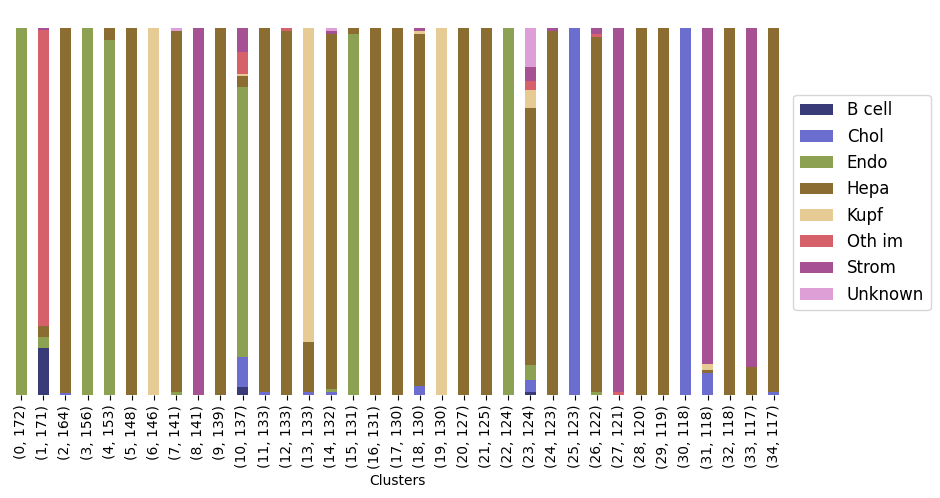

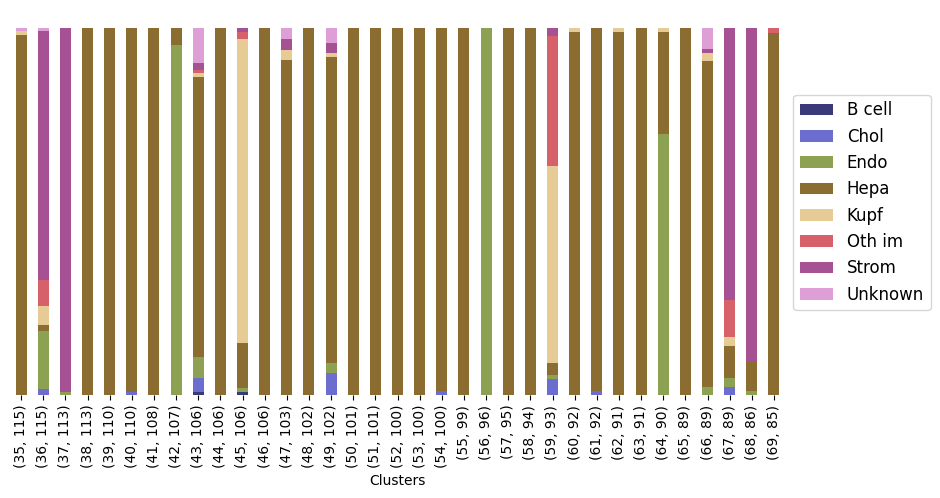

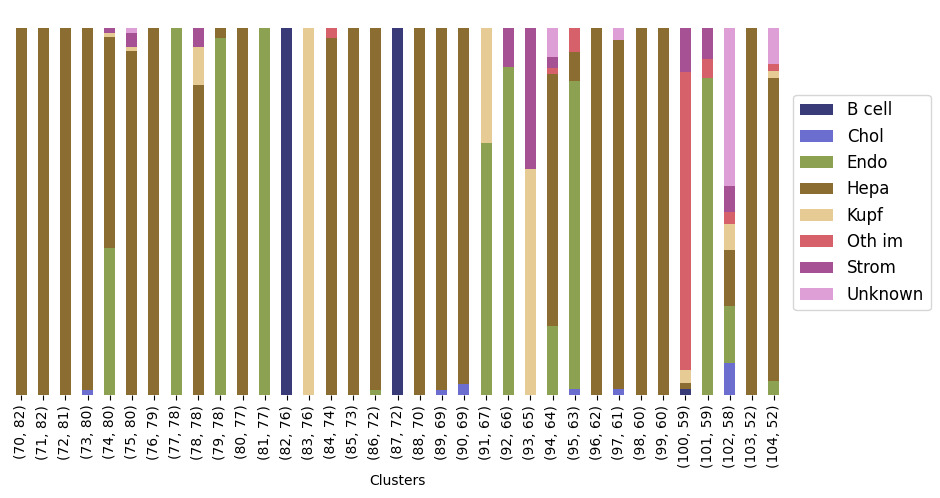

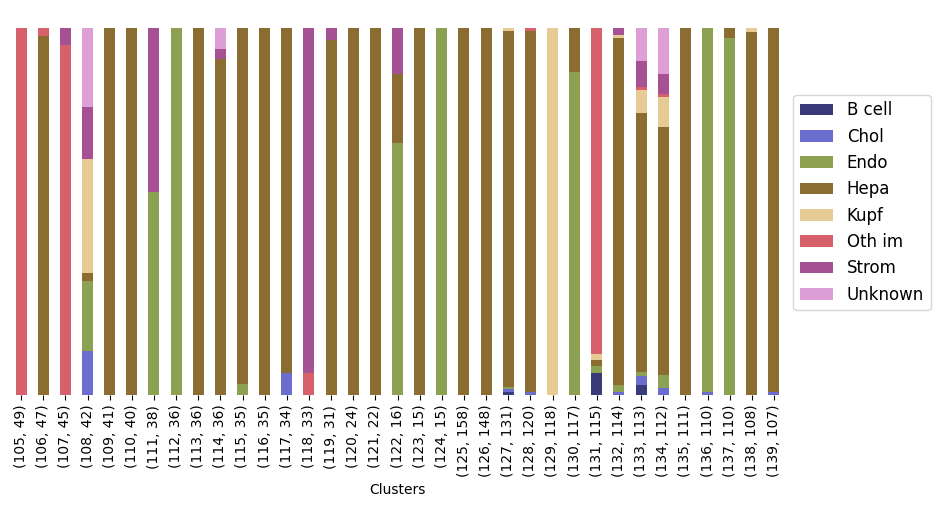

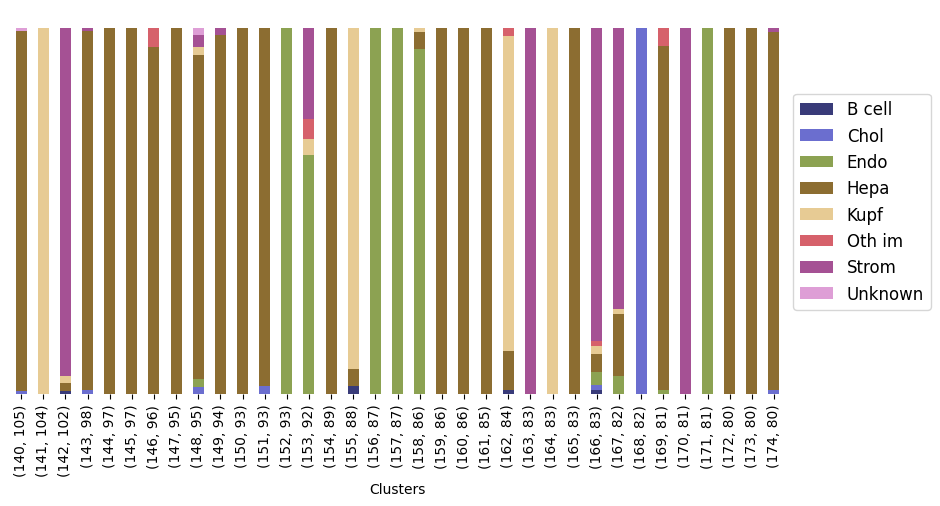

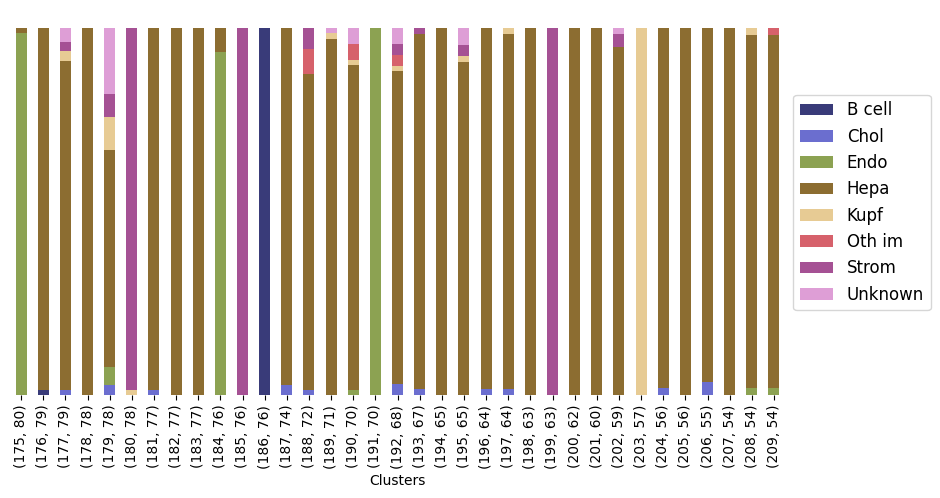

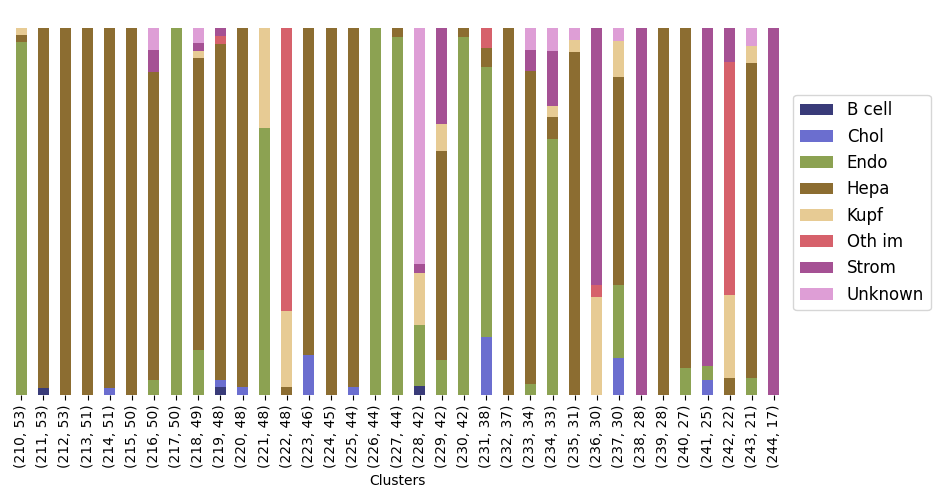

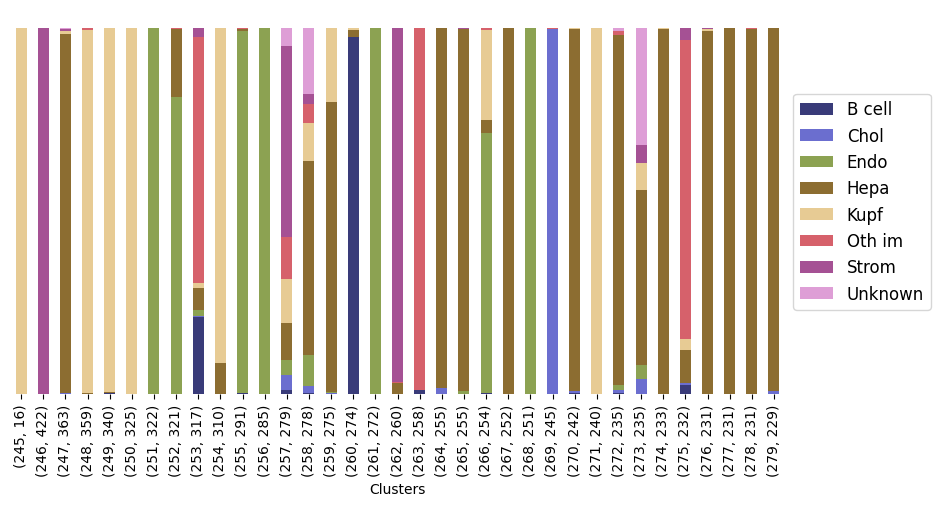

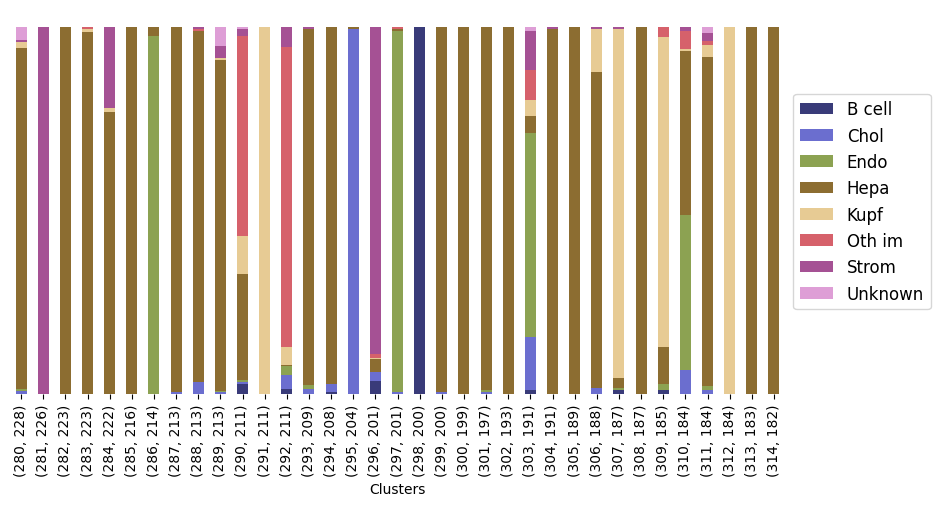

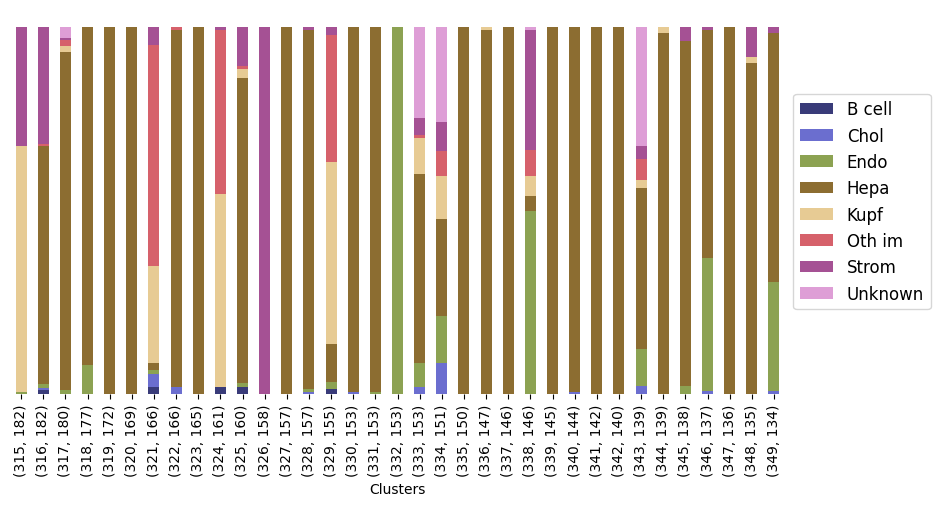

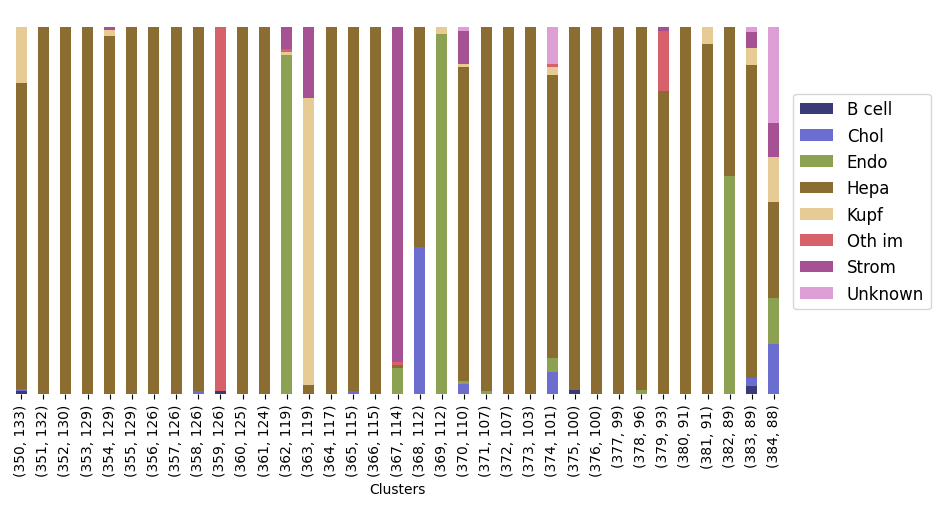

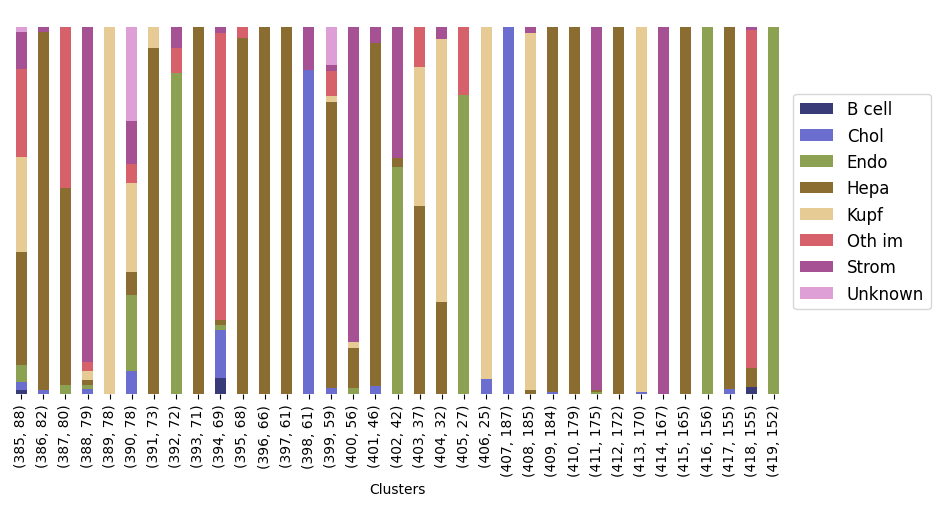

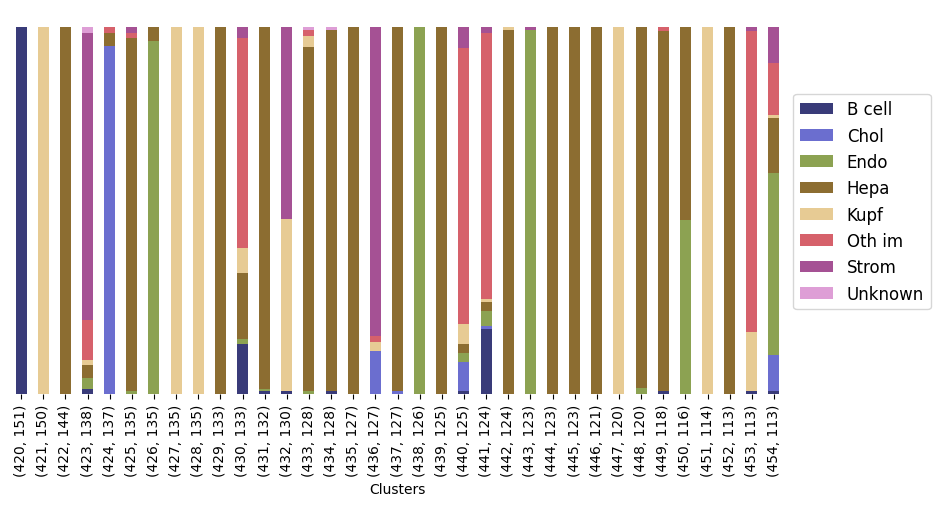

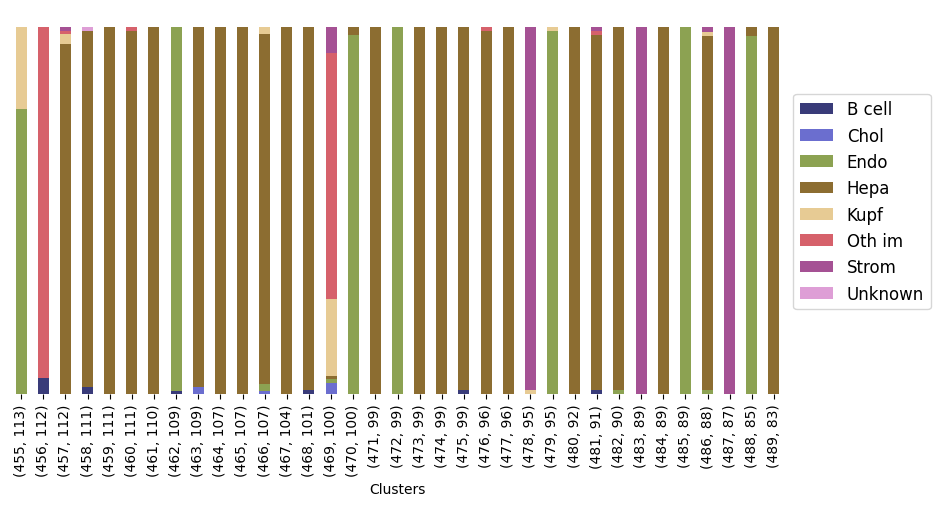

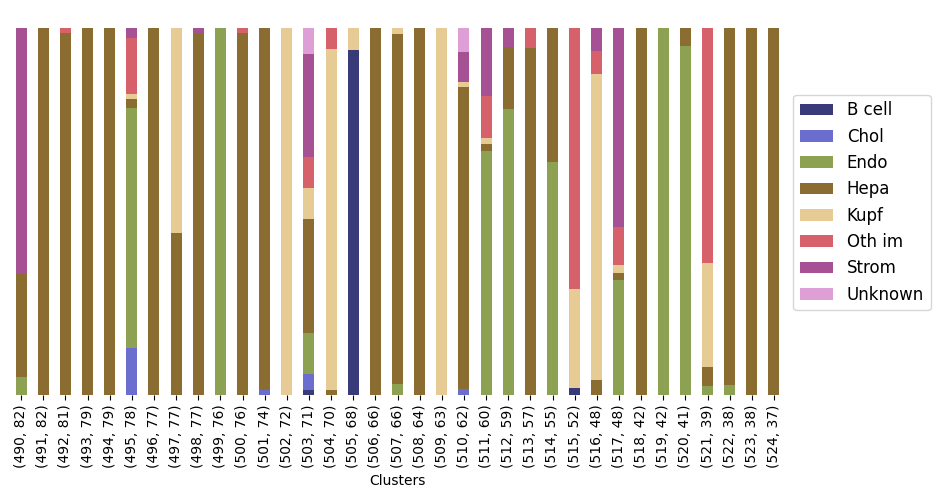

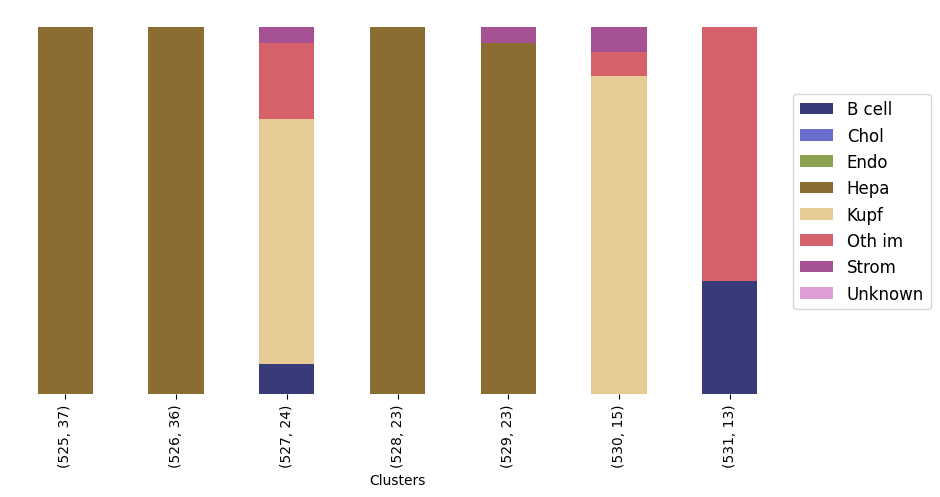

In [9]:
cell_types = anndata_samples_together.obs[annotation].unique().tolist()  
leiden_clusters_per_ct = clusteringVSleiden(anndata_samples_together,annotation,"leiden",cell_types=cell_types,print_results=True)

906 cells randomly sampled from each cell type in every iteration to do the DEG analysis
Summary:
Chol
Maybe drop:[['Fn1', 'Hepa']]
Strom
Maybe drop:[['Fn1', 'Hepa']]
Summary:
Chol
Maybe drop:[['Fn1', 'Hepa']]
Strom
Maybe drop:[['Fn1', 'Hepa']]
0    1   
Fn1  Hepa    2
dtype: int64
0    1   
Fn1  Hepa    2
dtype: int64


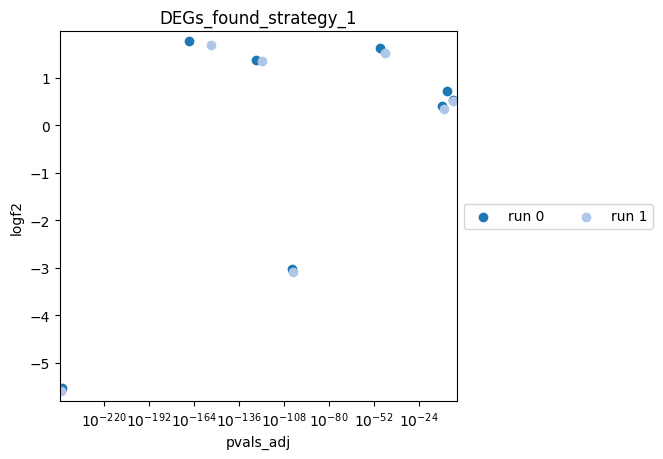

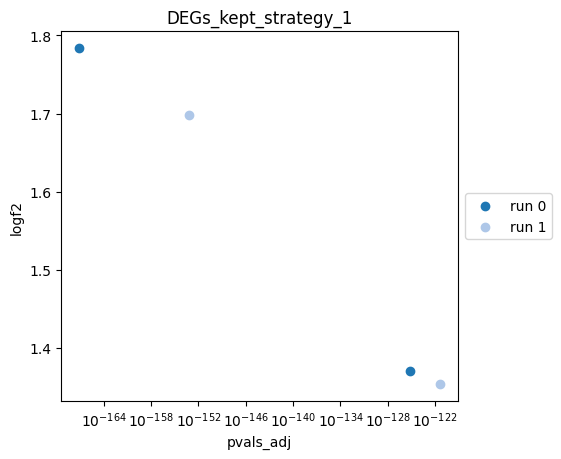

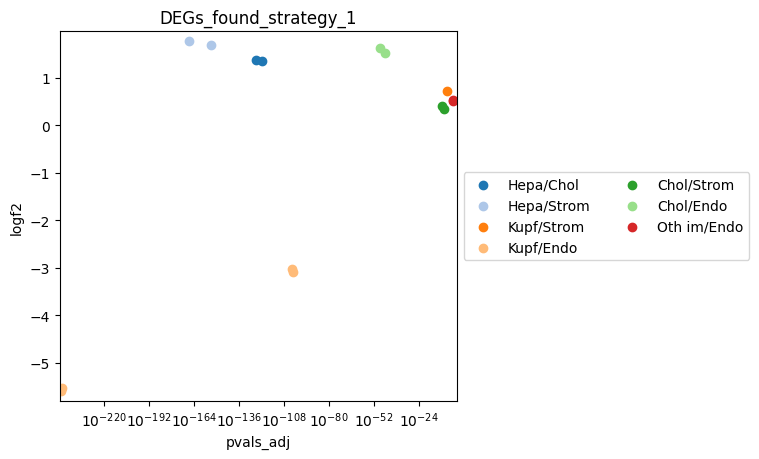

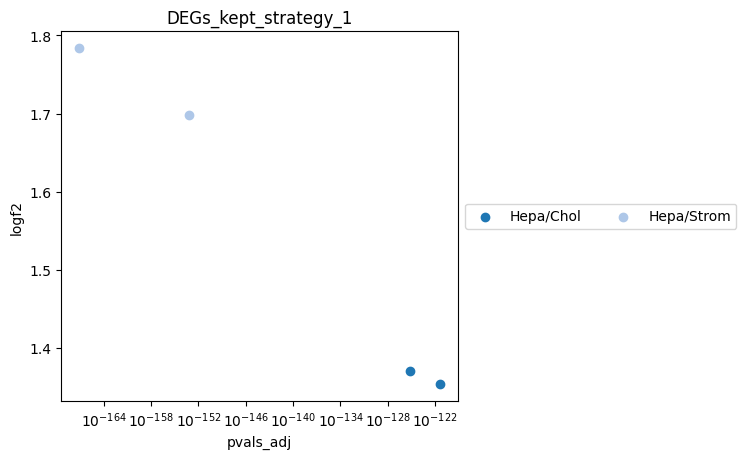

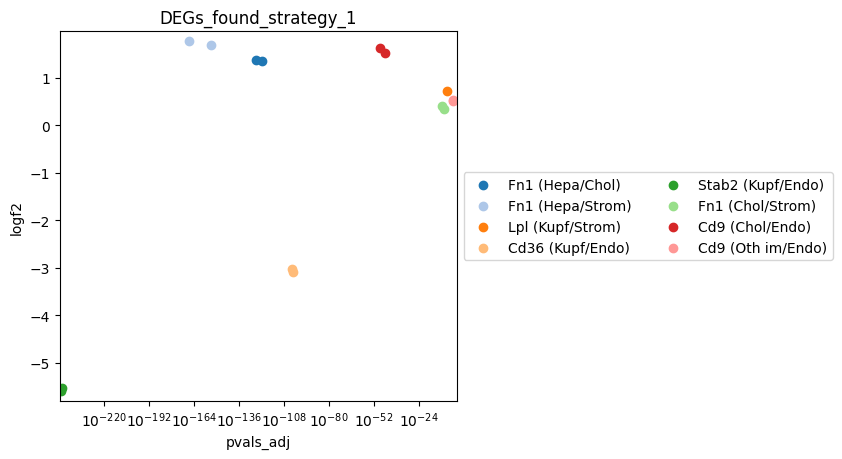

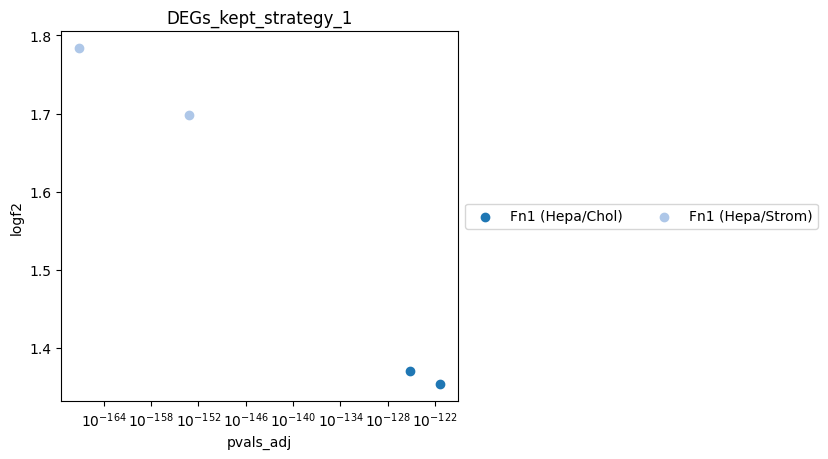

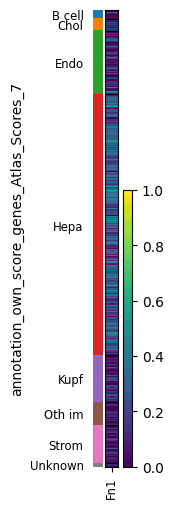

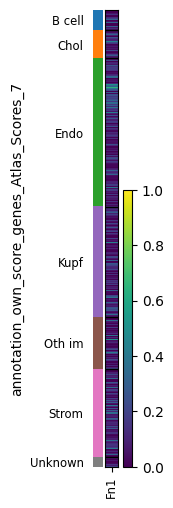

In [10]:
results_strat1_2, results_runs1_2, DEG_details_runs1_2 = Apply_strategy_multiple_times(anndata_samples_together,annotation,path_mg,2,1,OUTPUT_DIR)

In [11]:
results_strat1_2

{'Chol': [('Fn1', 'Hepa')], 'Strom': [('Fn1', 'Hepa')]}

In [12]:
results_runs1_2

{0: {'Chol': [['Fn1', 'Hepa'], ['Fn1', 'Hepa']],
  'Strom': [['Fn1', 'Hepa'], ['Fn1', 'Hepa']]},
 1: {'Chol': [['Fn1', 'Hepa']], 'Strom': [['Fn1', 'Hepa']]}}

In [13]:
DEG_details_runs1_2

{0: {'Hepa_Kupf': {'DEGs':        gene       pval_adj      logf2   ct1   ct2
   0      Pck1  2.088116e-175   2.214526  Hepa  Kupf
   1       Fn1  8.312493e-167   1.808559  Hepa  Kupf
   2       Ghr  9.923861e-150   1.677824  Hepa  Kupf
   3     Prox1  1.083506e-147   2.896821  Hepa  Kupf
   4       Hal   2.056732e-40   1.748316  Hepa  Kupf
   5       Sds   4.196992e-40   2.436246  Hepa  Kupf
   6     Gdf15   6.565917e-31   1.758378  Hepa  Kupf
   7      Gls2   1.539266e-25   1.474196  Hepa  Kupf
   8      Ngfr   3.414973e-21   0.955441  Hepa  Kupf
   9    Cyp2e1   1.935944e-13   1.401788  Hepa  Kupf
   10   Cxcl12   5.772161e-11   2.084936  Hepa  Kupf
   11    Mmp12   1.292442e-10   2.158745  Hepa  Kupf
   12     Sox9   9.401708e-06   1.558072  Hepa  Kupf
   13      Cd9   4.714079e-03   0.829578  Hepa  Kupf
   14     Lgr5   8.897253e-03   5.156813  Hepa  Kupf
   69    Itgb7   3.676371e-03 -21.979992  Hepa  Kupf
   70     Cd36   2.928334e-03  -1.263415  Hepa  Kupf
   71      Dpt   2.908